### Heatlth care premium prediction


#### Importing Libraries


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

#### Importing Data

In [5]:
df = pd.read_csv(r'data_above_25.csv')
df.head()

,Unnamed: 0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [6]:
df.shape

(29886, 14)

In [7]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


#### Handeling Null values

In [8]:
df.isnull().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
# As there are only few null values we can drop them
df.dropna(inplace=True)
df.isnull().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

#### Checking Duplicates

In [10]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Data Cleaning

In [11]:
df.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.000000
mean,25027.094091,43.396105,2.385933,23.364184,20892.303821
std,14432.632929,13.412657,1.421137,24.740339,6936.813440
min,0.000000,26.000000,0.000000,1.000000,3625.000000
25%,12599.250000,34.000000,1.000000,7.000000,15697.250000
50%,25067.500000,42.000000,3.000000,17.000000,20489.000000
75%,37563.750000,52.000000,3.000000,32.000000,26360.000000
max,49999.000000,356.000000,5.000000,930.000000,43471.000000


In [12]:
df[df.number_of_dependants < 0]

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


In [13]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([], dtype=int64)

In [14]:
# This can be a typo so lets change the sign instead of droping the data
df['number_of_dependants'] = abs(df.number_of_dependants)

In [15]:
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

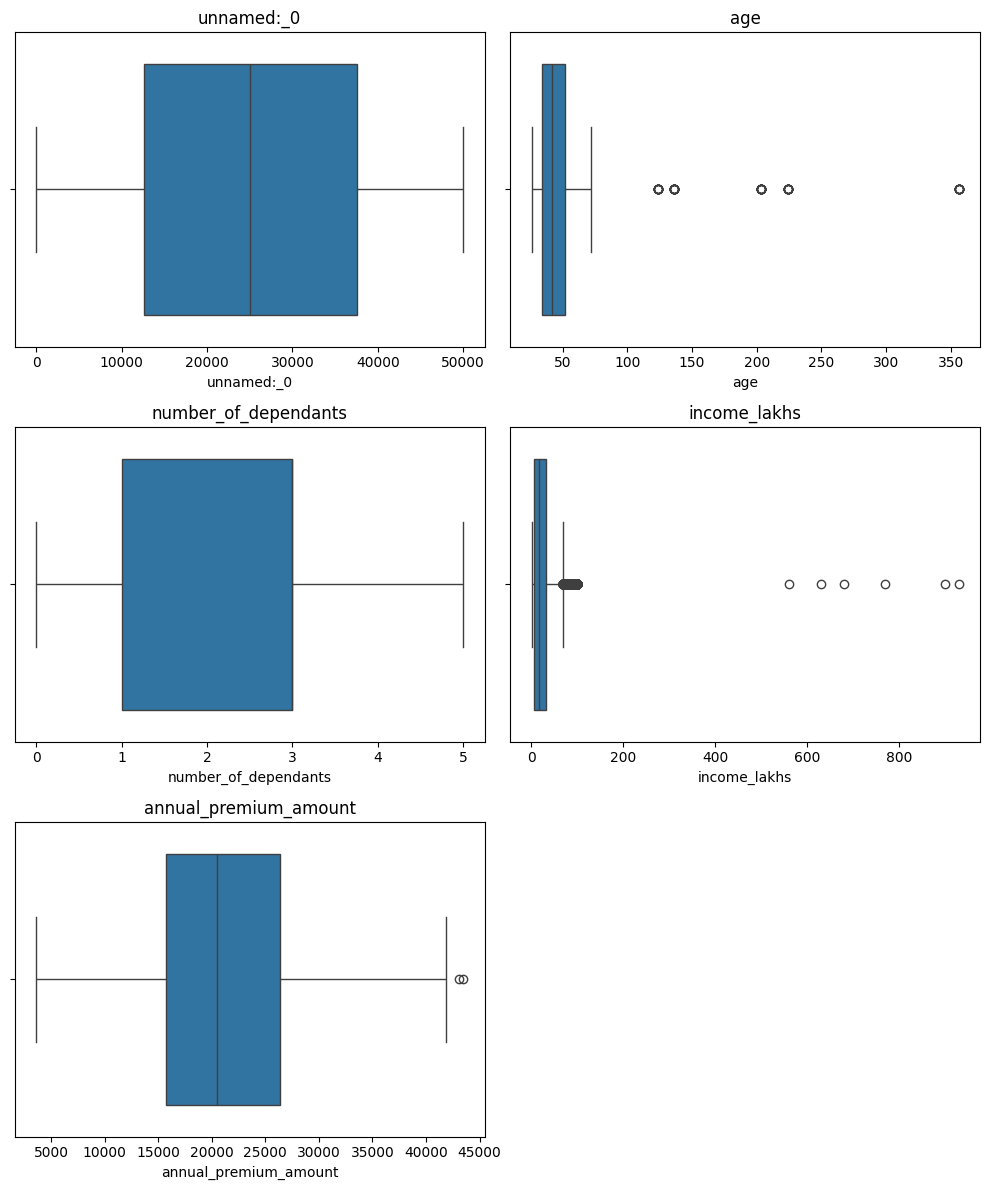

In [16]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns

n_cols = 2
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)

# remove empty subplot if odd number of columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [17]:
numeric_columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_lakhs',
       'annual_premium_amount'],
      dtype='object')

In [18]:
# Age column
df[df.age > 100].shape

(58, 14)

In [19]:
df[df.age > 100]['age'].unique()

array([224, 124, 136, 203, 356])

In [20]:
df1 = df.copy()
df1 = df1[df1.age <= 100]     # we remove the data points where age > 100

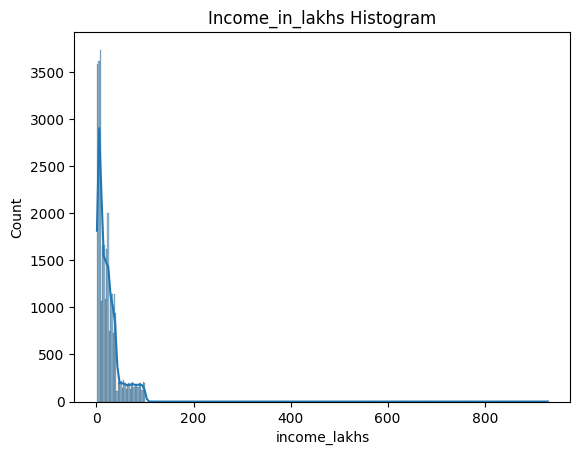

In [21]:
# income_lakhs
sns.histplot(df.income_lakhs, kde=True)
plt.title("Income_in_lakhs Histogram")
plt.show()

In [22]:
# We can us outlier detection using the Quantiles

def get_iqr_bound(df,col):
    q1,q3 = df[col].quantile([0.25,0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return [lower_bound, upper_bound]

iqr_bound = get_iqr_bound(df1, 'income_lakhs')
iqr_bound 

[-30.5, 69.5]

In [23]:
# Basically in INDIA 67 LPA is not a huge number so we will try different quantiles
quantile_value = df['income_lakhs'].quantile(0.999)
df2 = df1[df1.income_lakhs <= quantile_value].copy()
df2.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,25030.357152,43.094896,2.387734,23.226343,20900.689223
std,14431.397026,11.042430,1.420644,22.455408,6928.192115
min,0.000000,26.000000,0.000000,1.000000,6538.000000
25%,12605.250000,34.000000,1.000000,7.000000,15705.250000
50%,25070.000000,42.000000,3.000000,17.000000,20495.500000
75%,37565.500000,52.000000,3.000000,32.000000,26360.000000
max,49999.000000,72.000000,5.000000,100.000000,43471.000000


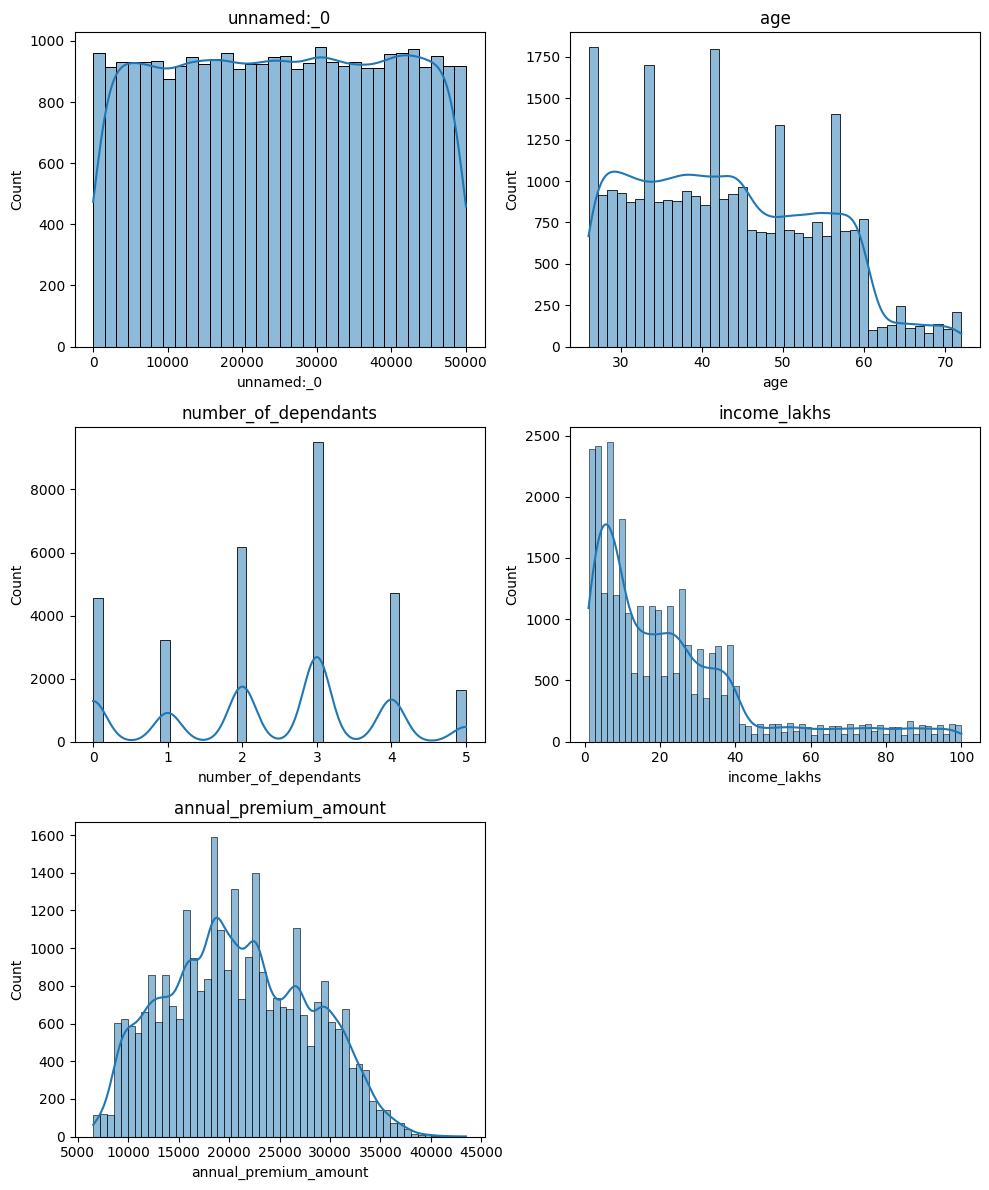

In [24]:
n_cols = 2
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# remove empty subplot if odd number of columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

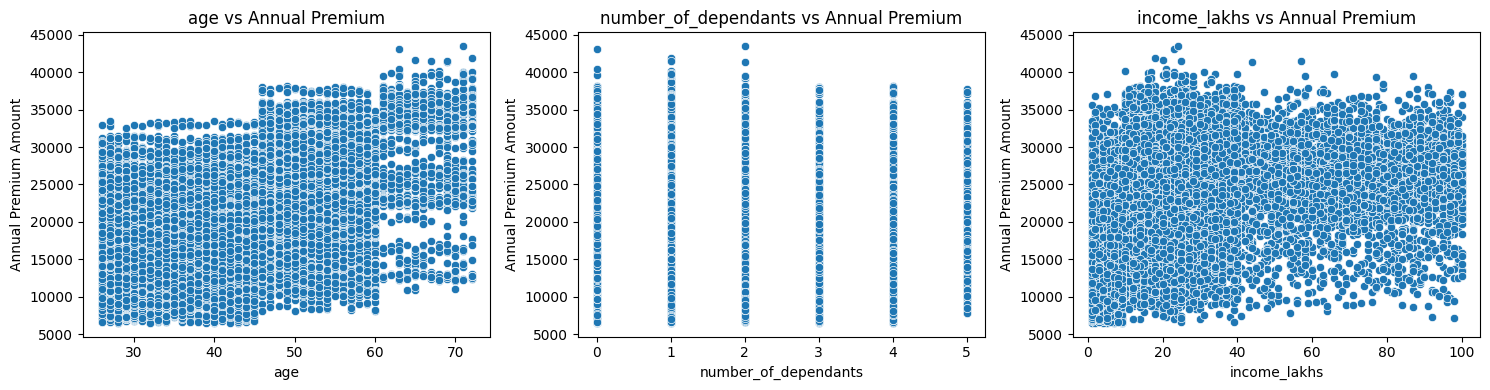

In [25]:
n_cols = ['age', 'number_of_dependants', 'income_lakhs']

n = len(n_cols)

fig, axes = plt.subplots(1, n, figsize=(5*n, 4))

# if only one column, make axes iterable
if n == 1:
    axes = [axes]

for ax, col in zip(axes, n_cols):
    sns.scatterplot(data=df2, x=col, y='annual_premium_amount', ax=ax)
    ax.set_title(f'{col} vs Annual Premium')
    ax.set_xlabel(col)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [26]:
cat_columns = df2.select_dtypes(['object']).columns
for col in cat_columns:
    print(f"{col} : {df2[col].unique()}")

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [27]:
df2['smoking_status'].replace({
    'Smoking=0' : 'No Smoking',
      'Does Not Smoke' : 'No Smoking',
 'Not Smoking' : 'No Smoking'
}, inplace=True)

C:\Users\maddi\AppData\Local\Temp\ipykernel_18376\1739571332.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


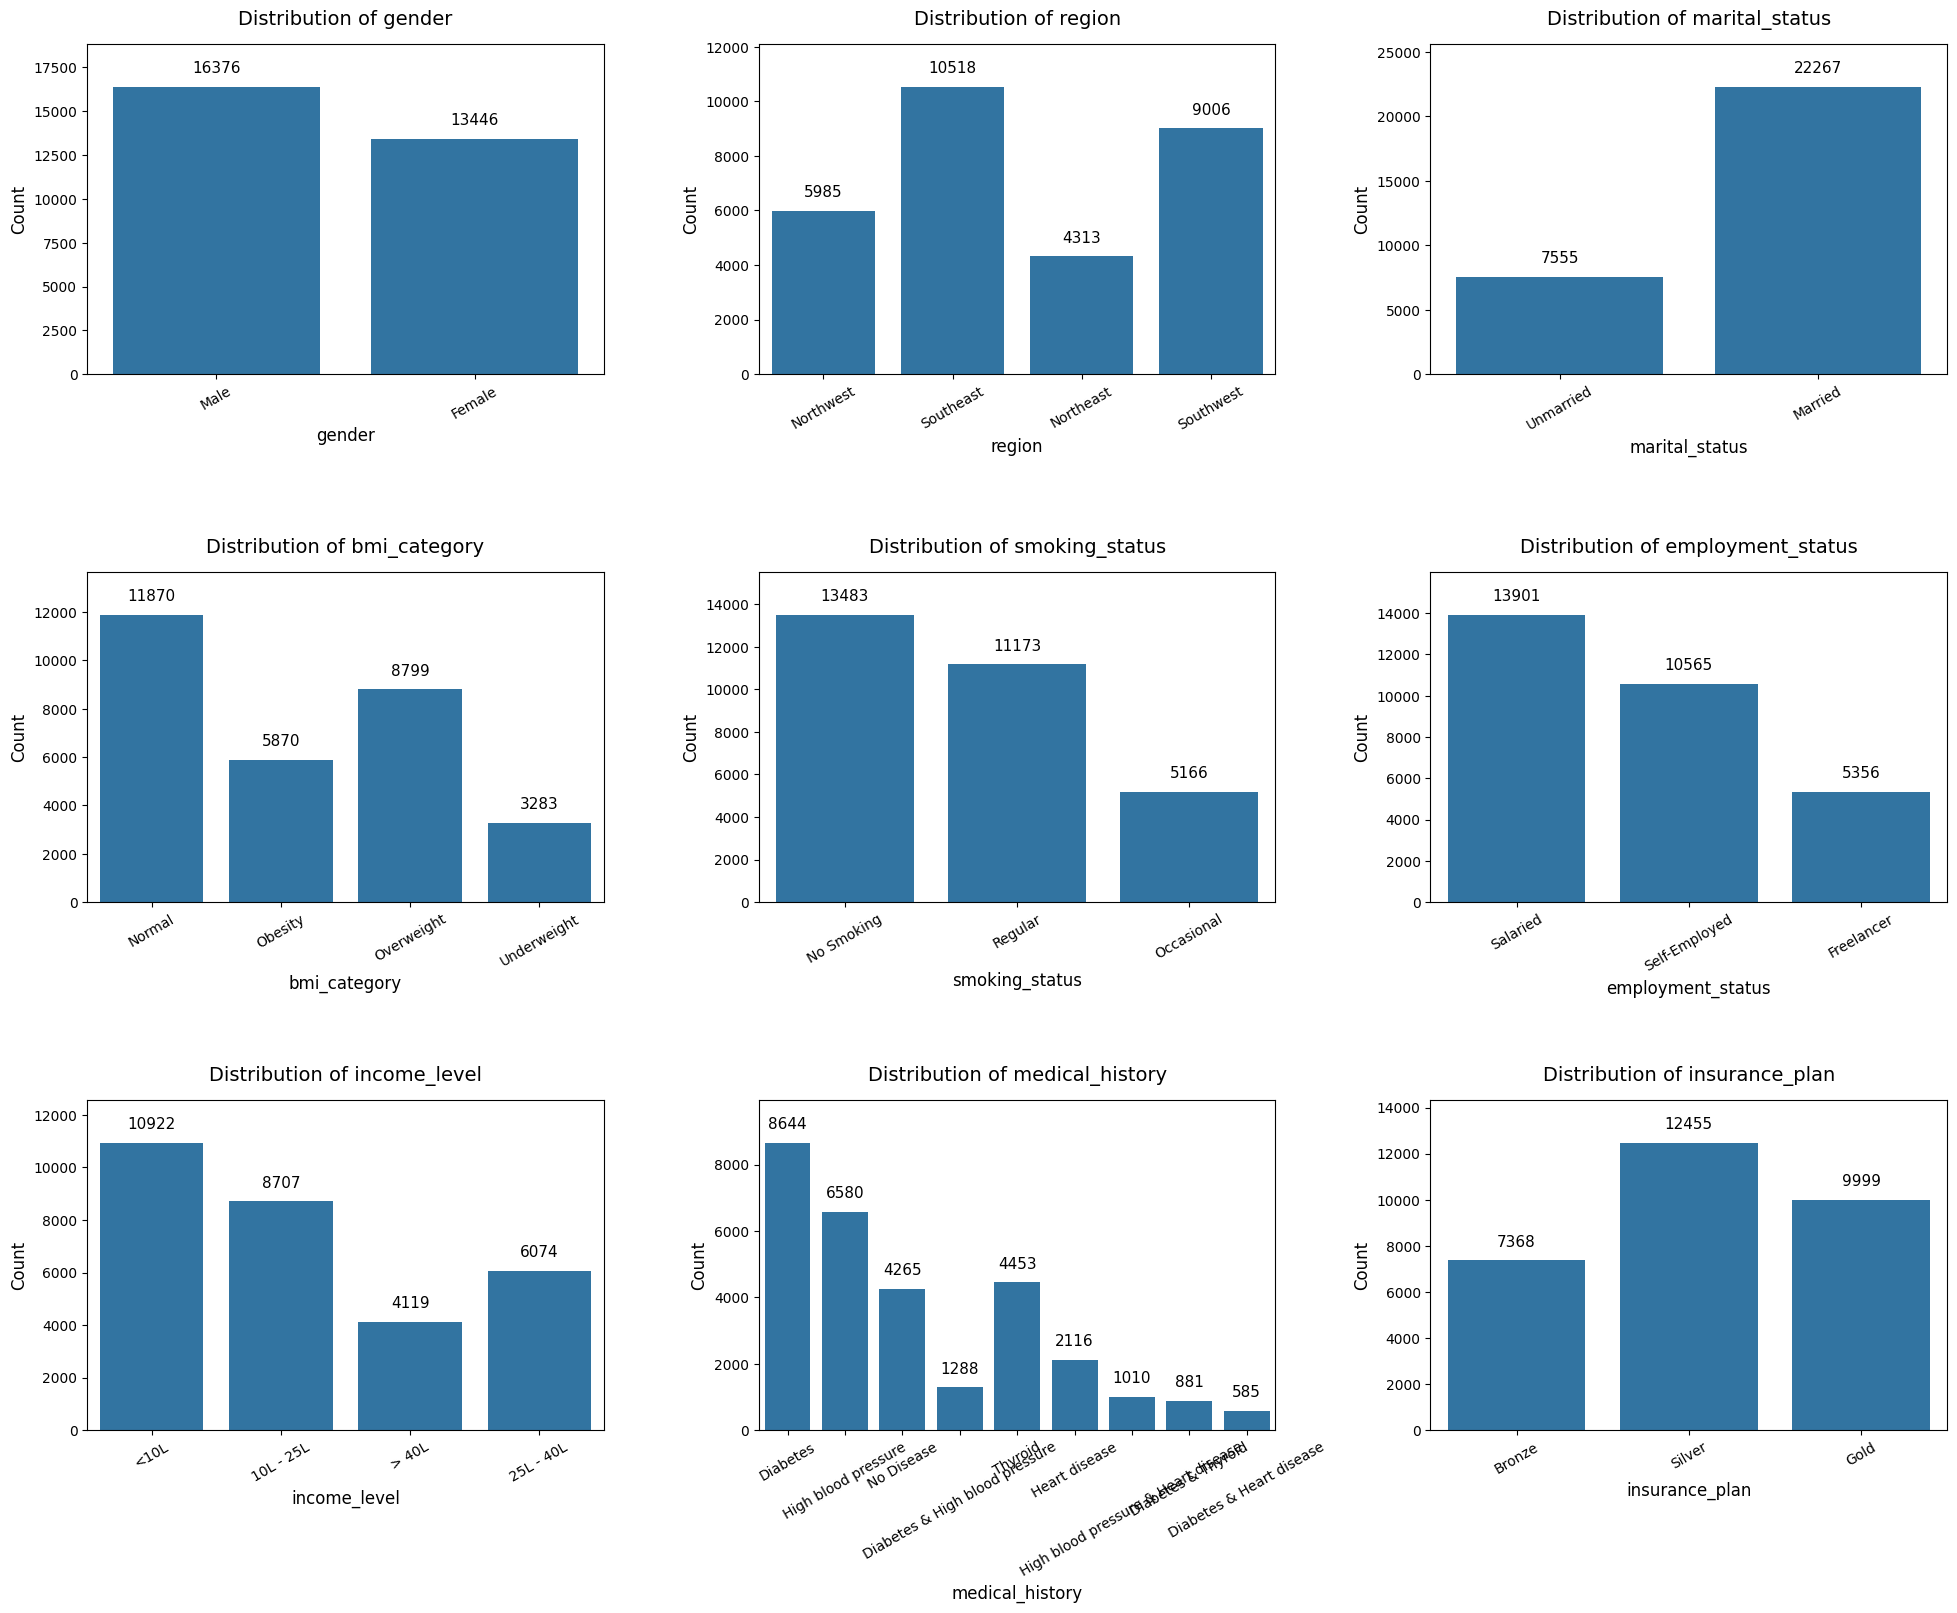

In [28]:
n_cols = 3   # 🔑 3 plots per row
n_rows = math.ceil(len(cat_columns) / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(8*n_cols, 6*n_rows)
)
axes = axes.flatten()

for i, col in enumerate(cat_columns):
    ax = axes[i]
    sns.countplot(data=df2, x=col, ax=ax)

    ax.set_title(f'Distribution of {col}', fontsize=14, pad=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=30)

    # Add labels
    for container in ax.containers:
        ax.bar_label(container, padding=8, fontsize=11)

    # Add headroom
    max_count = max(bar.get_height() for bar in ax.patches)
    ax.set_ylim(0, max_count * 1.15)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.show()


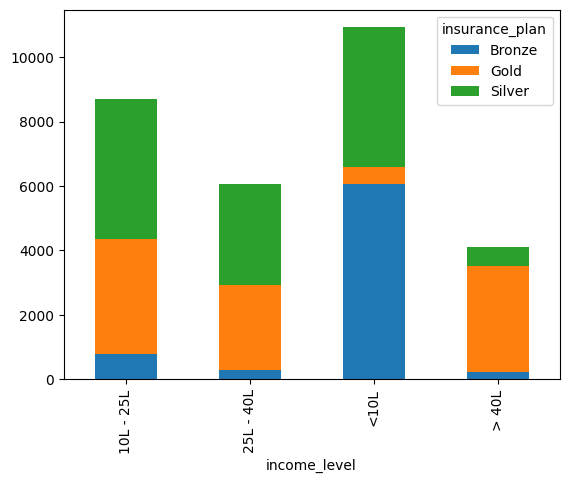

In [29]:
crostabs = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crostabs.plot(kind='bar', stacked=True)
plt.show()

### Feature Engineering

In [30]:
# medical_history columns
risk_scores = {
    'diabetes' : 6,
    'heart disease' : 8,
    'high blood pressure' : 6,
    'thyroid' : 5,
    'no disease' : 0,
    'none' : 0
}
df_ = pd.DataFrame()
df_[['disease_1', 'disease_2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x : x.str.lower())
df_ = df_[['disease_1', 'disease_2']]
df_.fillna('none', inplace=True)
df_

,disease_1,disease_2
0,diabetes,none
1,diabetes,none
2,high blood pressure,none
3,no disease,none
4,diabetes,none
...,...,...
29881,high blood pressure,none
29882,diabetes,thyroid
29883,no disease,none
29884,thyroid,none


In [31]:
df_['disease_1_num'] = df_['disease_1'].apply(lambda x : risk_scores[x])
df_['disease_2_num'] = df_['disease_2'].apply(lambda x : risk_scores[x])
df2['total_risk_scores'] = df_['disease_1_num'] + df_['disease_2_num']
df2['total_risk_scores_normalized'] = df2['total_risk_scores'].apply(lambda x : (x - df2['total_risk_scores'].min())/(df2['total_risk_scores'].max() - df2['total_risk_scores'].min()))

In [32]:
df2.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,total_risk_scores,total_risk_scores_normalized
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,6,0.428571
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,6,0.428571
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,6,0.428571
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,0.000000
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,6,0.428571


In [33]:
df2['insurance_plan'] = df2['insurance_plan'].map({
    'Bronze' : 1,
      'Silver' : 2,
        'Gold' : 3
})

df2['income_level'] = df2['income_level'].map({
    '<10L' : 1,
      '10L - 25L' : 2,
        '> 40L' : 3,
          '25L - 40L' : 4
})

onehot_cols = ['gender','region', 'marital_status', 'bmi_category','smoking_status','employment_status']
df2 = pd.get_dummies(df2, columns=onehot_cols, drop_first=True, dtype=int)


In [34]:
df2.drop(['total_risk_scores','medical_history'], axis='columns', inplace=True)

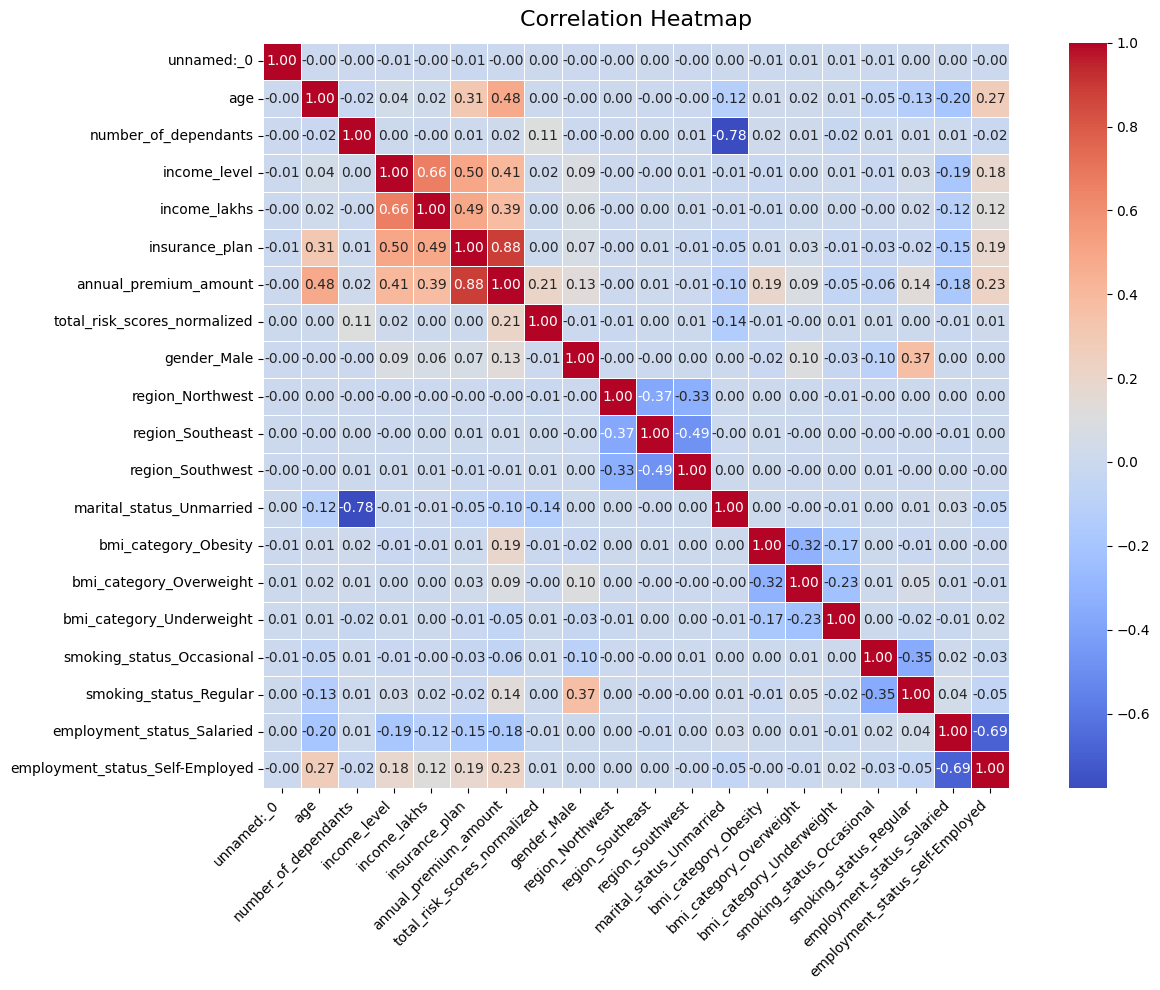

In [35]:
plt.figure(figsize=(14, 10))   # 🔑 increase figure size

cor = df2.corr()

sns.heatmap(
    cor,
    annot=True,                 # numbers inside each block
    fmt=".2f",                  # 2 decimal places
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    annot_kws={"size": 10}      # control number font size
)

plt.title("Correlation Heatmap", fontsize=16, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [36]:
df2.head(2)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_scores_normalized,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [37]:
X = df2.drop('annual_premium_amount', axis='columns')
y = df2['annual_premium_amount']
scale_columns = ['age', 'number_of_dependants', 'income_level','income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()
X[scale_columns] = scaler.fit_transform(X[scale_columns])


In [38]:
# Variance Inflation Factor
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['columns'] = data.columns
    vif_df['VIF_Factor'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

,columns,VIF_Factor
0,unnamed:_0,3.708663
1,age,3.918273
2,number_of_dependants,6.586035
3,income_level,4.105058
4,income_lakhs,3.798575
5,insurance_plan,4.932261
6,total_risk_scores_normalized,3.851385
7,gender_Male,2.600772
8,region_Northwest,2.144300
9,region_Southeast,3.017075


### Model Training

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

### Linear Regression

In [40]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9530831643886374, 0.9546142004576978)

In [41]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2183682.7846360435 RMSE:  1477.7289279959446


In [42]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([    0.000567,  7013.109102, -1248.033645,   -11.358264,
        -738.861313, 14843.090526,  6029.203204,    43.178283,
         -76.197249,   -25.219658,   -53.264682,  -702.211144,
        3930.459859,  1998.859809,   598.33475 ,   855.345622,
        2816.90962 ,   -74.150976,   249.024617])

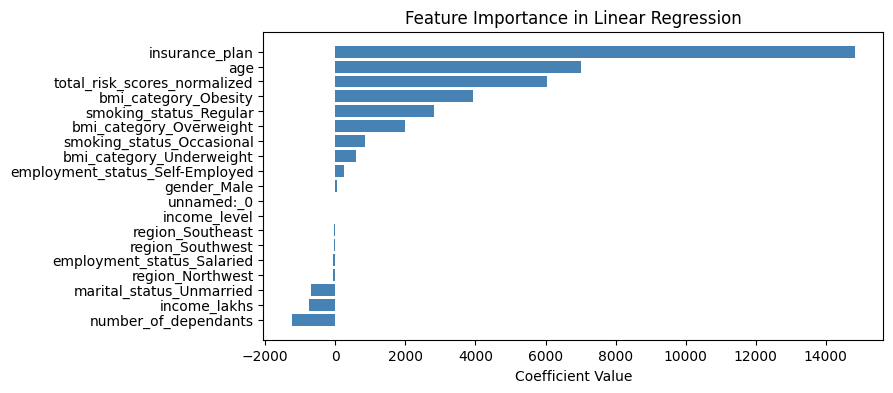

In [43]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression

In [44]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9530829928549726, 0.9546143957991106)

In [45]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  2183673.38602052 RMSE:  1477.725747904705


### XGBoost

In [46]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9950187802314758

In [47]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  239665.8125 RMSE:  489.5567510513975


In [48]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9970053235689799)

In [49]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [50]:
best_model = random_search.best_estimator_

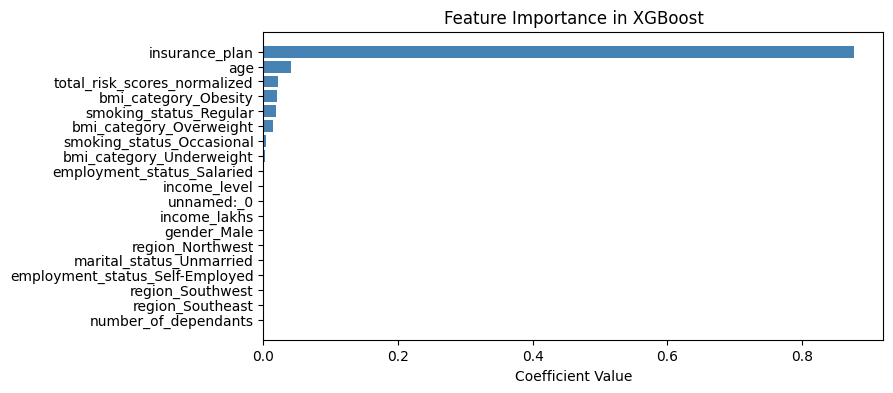

In [51]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### Error Analysis

In [52]:
y_pred = best_model.predict(X_test)
error = y_pred - y_test
error_precent = error*100/y_test

residuals_data = pd.DataFrame(
    {'y_predicted' : y_pred,
    'y_tested' : y_test,
    'error' : error,
    'error_precent' : error_precent}
)
residuals_data.head()

,y_predicted,y_tested,error,error_precent
5493,31168.617188,30838,330.617188,1.072110
581,26138.771484,26306,-167.228516,-0.635705
280,17611.267578,17983,-371.732422,-2.067132
15430,18925.273438,19345,-419.726562,-2.169690
24266,33256.781250,33317,-60.218750,-0.180745


<Axes: xlabel='error_precent', ylabel='Count'>

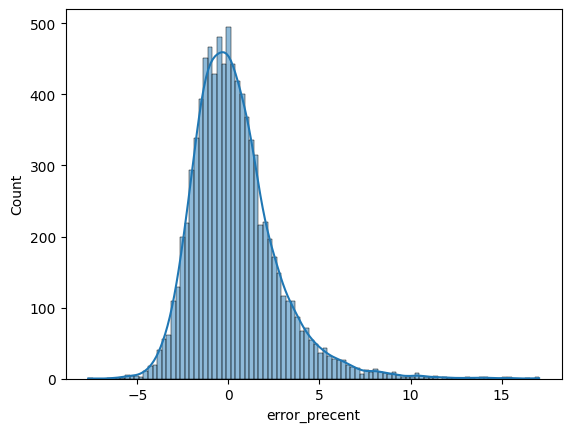

In [53]:
sns.histplot(residuals_data['error_precent'], kde = True)

In [54]:
# The errors should not be more than 10%

extreme_error_limit = 10
extreme_error_df = residuals_data[abs(residuals_data.error_precent) > extreme_error_limit]
extreme_error_df.shape

(45, 4)

In [55]:
residuals_data.shape

(8947, 4)

In [56]:
extreme_error_pct = (( extreme_error_df.shape[0])/residuals_data.shape[0])
extreme_error_pct

0.005029618866659215

In [57]:
extreme_results_df = X_test.loc[extreme_error_df.index]
extreme_results_df.shape

(45, 19)

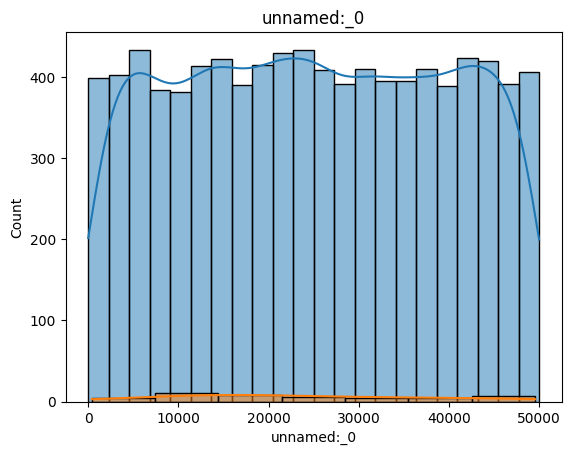

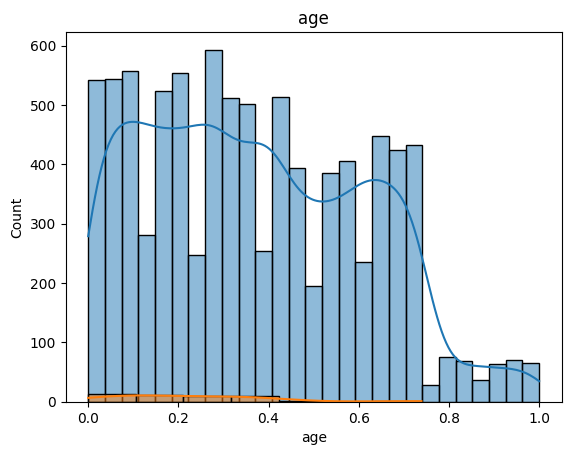

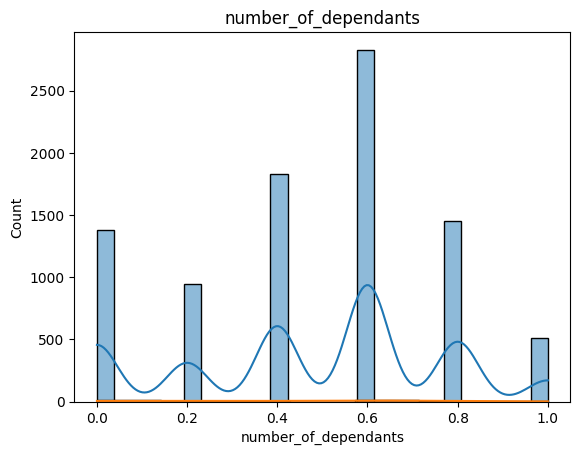

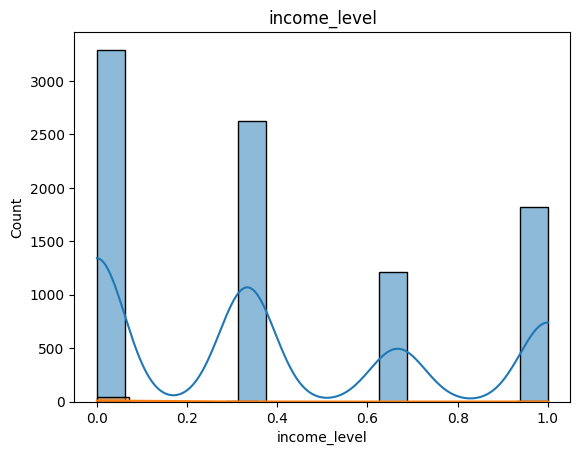

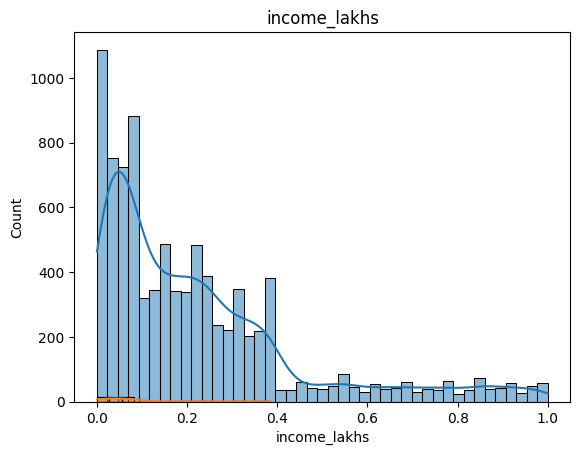

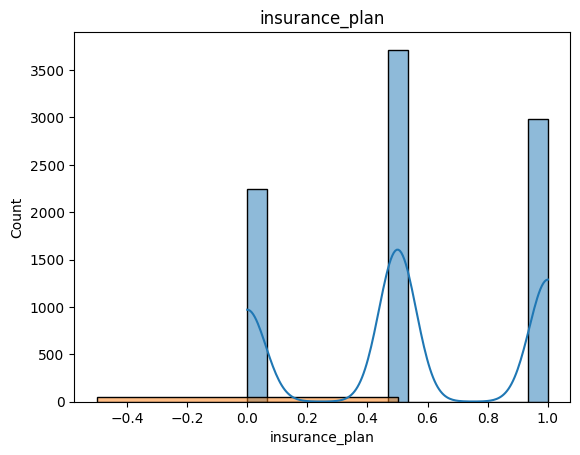

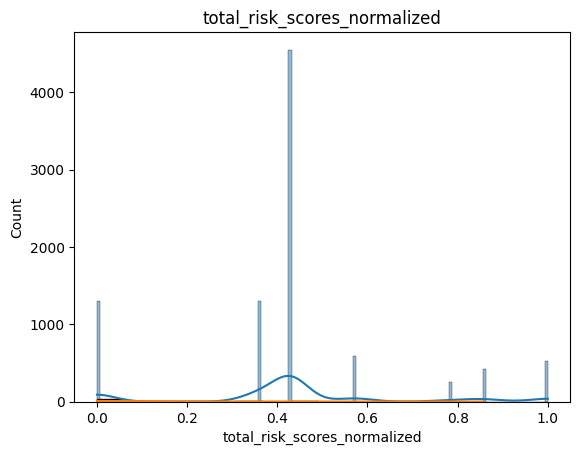

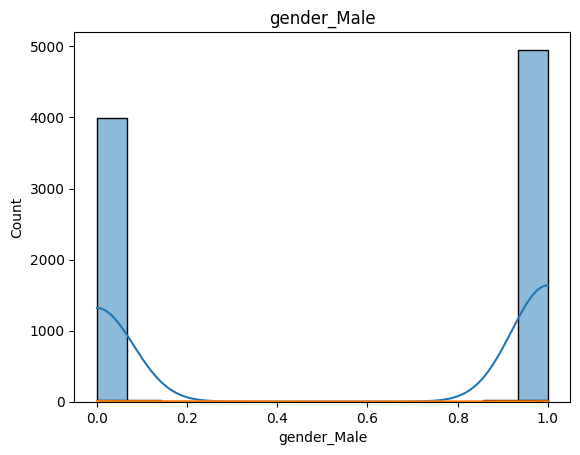

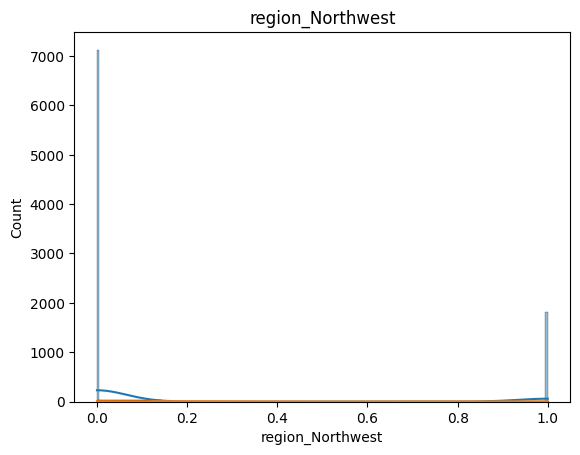

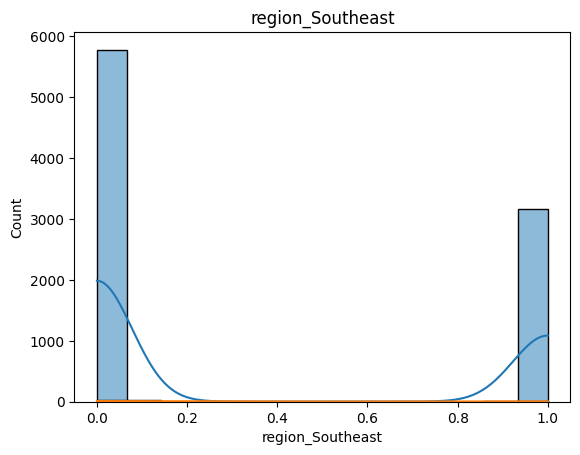

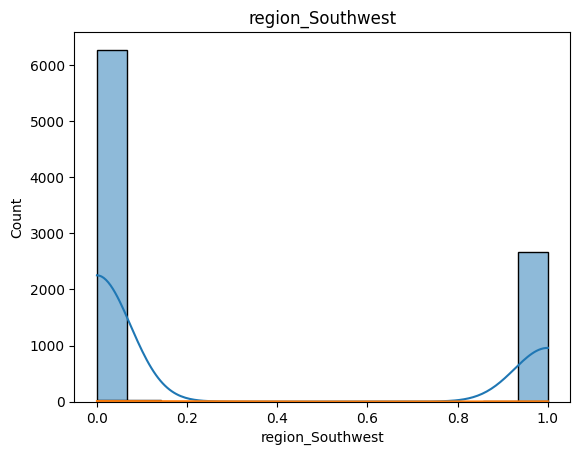

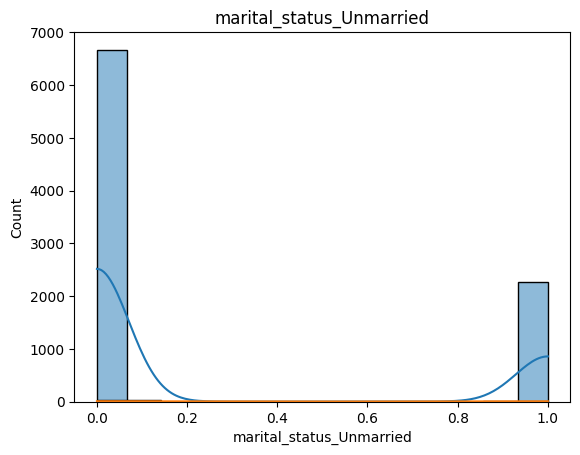

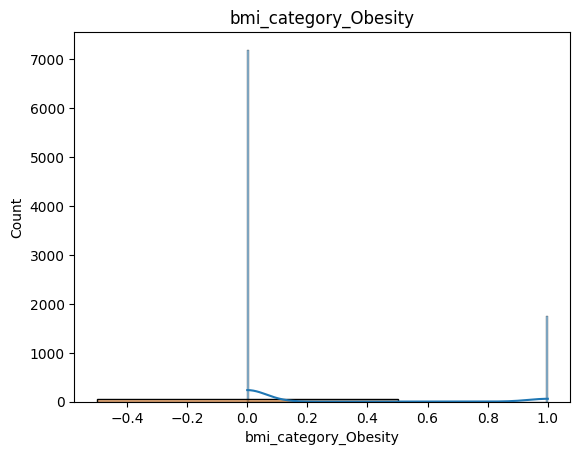

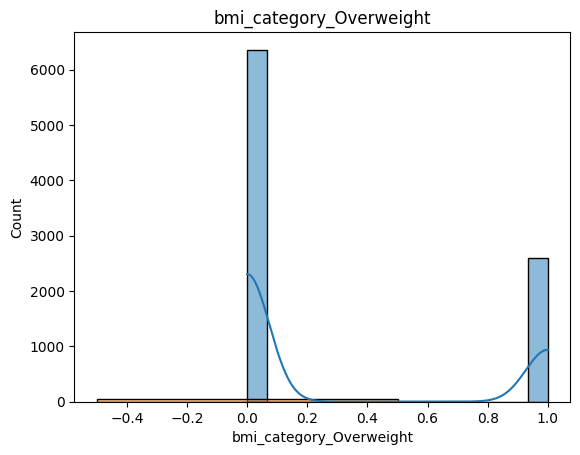

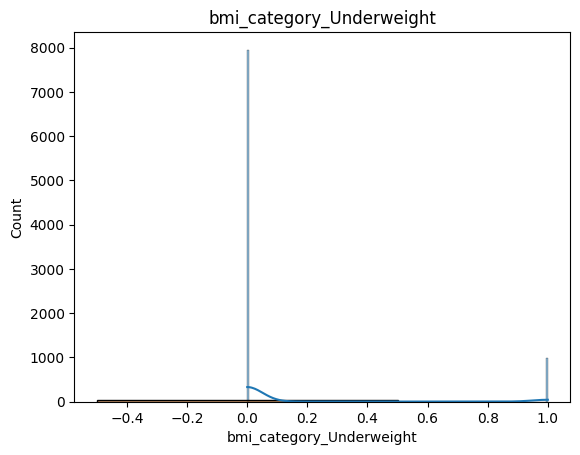

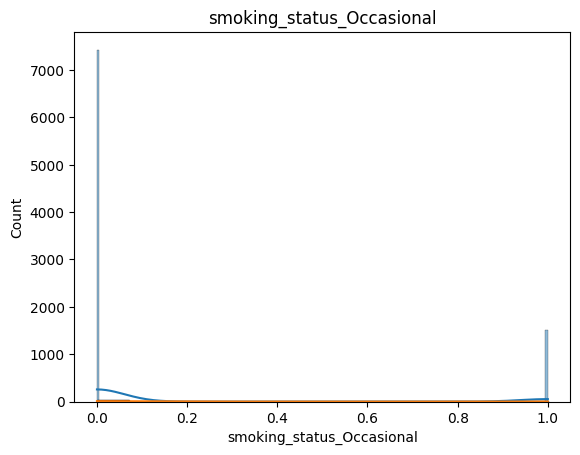

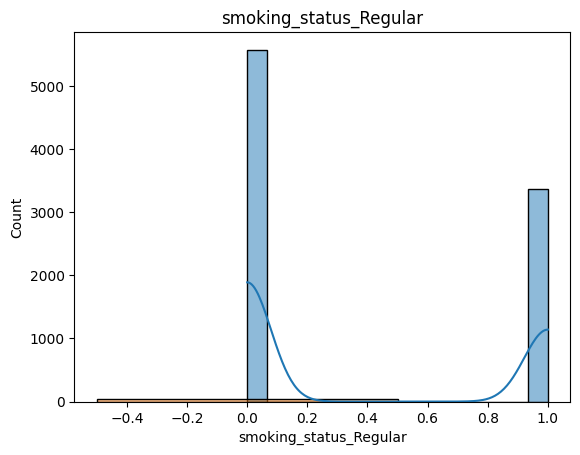

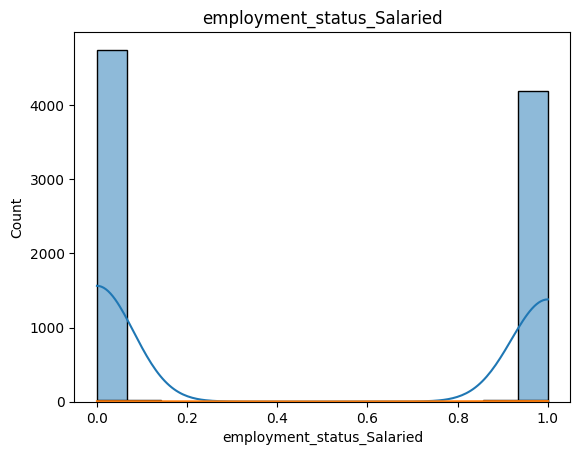

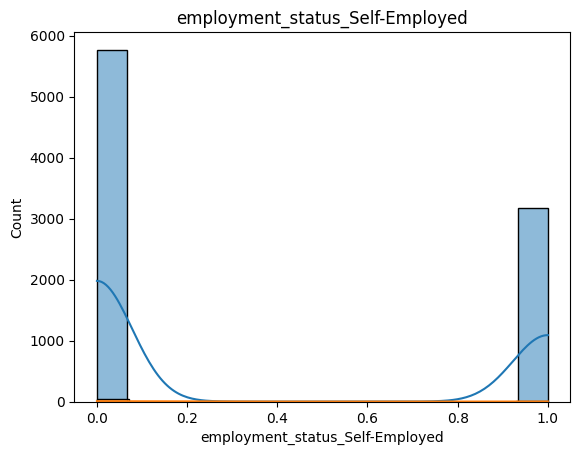

In [58]:
for feature in X.columns:
    sns.histplot(X_test[feature], label = "Overall", kde=True)
    sns.histplot(extreme_results_df[feature], label = "Error", kde=True)
    plt.title(feature)
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

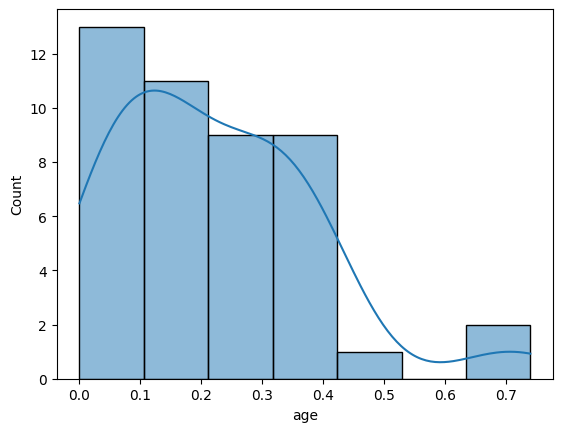

In [59]:
sns.histplot(extreme_results_df.age, kde= True)

In [60]:
df_rev = pd.DataFrame()
df_rev[scale_columns] = scaler.inverse_transform(extreme_results_df[scale_columns])

In [61]:
df_rev.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,45.000000,45.000000,45.000000,45.000000,45.0
mean,36.200000,2.088889,1.244444,7.688889,1.0
std,7.641394,1.474360,0.773292,7.908058,0.0
min,26.000000,0.000000,1.000000,1.000000,1.0
25%,30.000000,1.000000,1.000000,3.000000,1.0
50%,35.000000,3.000000,1.000000,6.000000,1.0
75%,41.000000,3.000000,1.000000,8.000000,1.0
max,60.000000,5.000000,4.000000,39.000000,1.0


In [62]:
x = df_rev['age'].quantile(0.99)
x

np.float64(58.68000000000001)

In [63]:
age_above_25 = df[df.age > 25]
age_below_25 = df[df.age <= 25]